In [1]:
import yfinance as yf
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as sps

In [ ]:
spy = yf.download("SPY", start="2010-01-01", end="2025-01-01")
time.sleep(5)
nvda = yf.download("NVDA", start="2010-01-01", end="2025-01-01")

In [32]:
x = yf.download("X",start="2010-01-01", end="2025-01-01")
x.to_csv("x.csv")

[*********************100%***********************]  1 of 1 completed


In [2]:
nvda.to_csv('nvda.csv')
spy.to_csv('spy.csv')

In [7]:
print(nvda.shape)
print(nvda.columns)
print(spy.columns)

(3774, 5)
MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [30]:
print(spy.iloc[0].shape)
print(2*3774*2)

(8,)
15096


In [2]:
def load_data(file):
    xdat = pd.read_csv(file,skiprows=2)

    xdat.columns = ['Date','Close','High','Low','Open','Volume']
    xdat['Date'] = pd.to_datetime(xdat['Date'])
    
    return xdat

In [3]:
def plot_data(xdat:pd.DataFrame):
    plt.plot(xdat['Date'],xdat['Close'])
    plt.title("Prices")
    plt.show()

    xdat['logReturns'] = np.log1p(xdat.Close).diff()
    xdat['Squared_logReturns'] = (xdat.logReturns)**2

    plt.plot(xdat['Date'],xdat['logReturns'])
    plt.title("log-Returns")
    plt.show()

    plt.plot(xdat['Date'],xdat['Squared_logReturns'])
    plt.title("Squared log-Returns")
    plt.show()

# Asset 1

           Date      Close       High        Low       Open     Volume
3517 2023-12-22  48.811672  49.364462  48.448806  49.176533  252507000
3518 2023-12-26  49.260498  49.581377  48.941618  48.949614  244200000
3519 2023-12-27  49.398449  49.661351  49.066573  49.492415  233648000
3520 2023-12-28  49.503410  49.865274  49.393451  49.624367  246587000
3521 2023-12-29  49.503410  49.978234  48.732700  49.794301  389293000


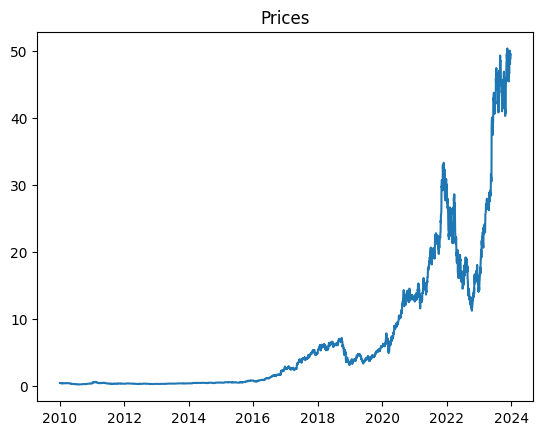

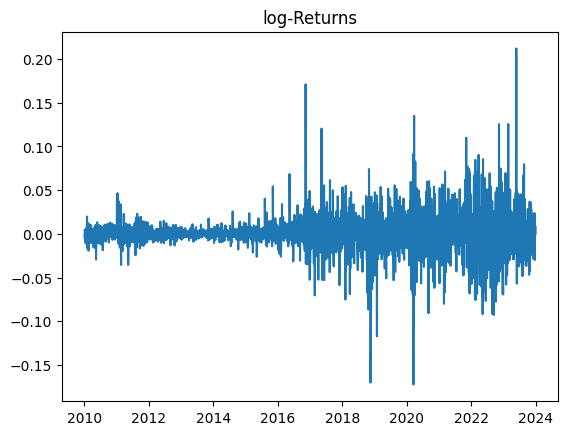

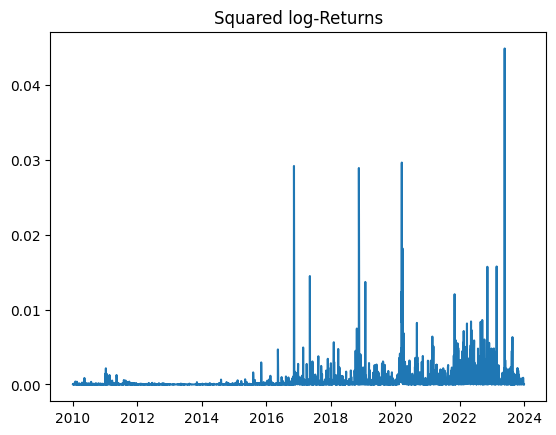

In [5]:
ticket = "nvda"
nvda = load_data(ticket + ".csv")
nvda = nvda[nvda['Date'] <= '2023-12-31']
print(nvda.tail())
plot_data(nvda)

# Asset 2

        Date      Close       High        Low       Open     Volume
0 2010-01-04  85.768433  85.813839  84.391052  85.041903  118944600
1 2010-01-05  85.995483  86.033326  85.405178  85.715470  111579900
2 2010-01-06  86.056015  86.267919  85.844111  85.912221  116074400
3 2010-01-07  86.419296  86.525248  85.654924  85.897101  131091100
4 2010-01-08  86.706879  86.744721  86.018191  86.192253  126402800


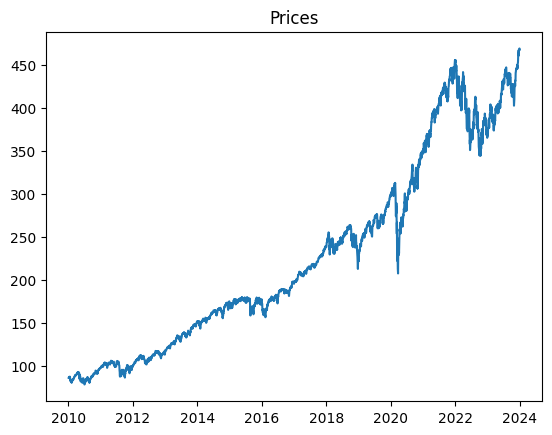

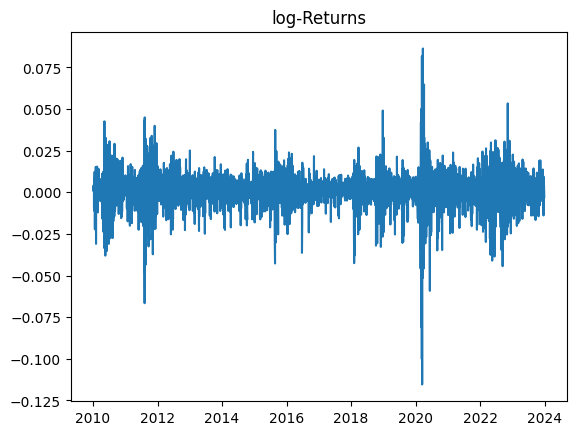

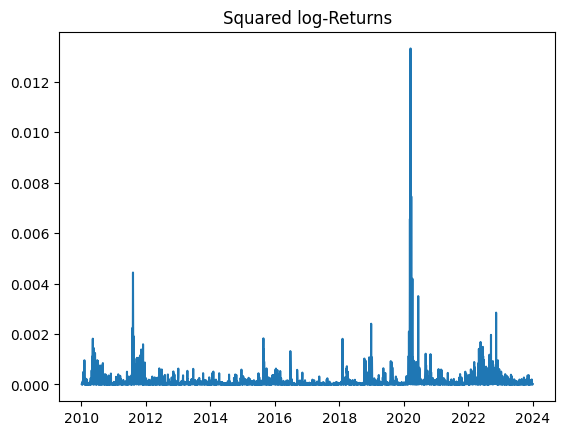

In [6]:
ticket = "spy"
spy = load_data(ticket+".csv")
spy = spy[spy['Date'] <= '2023-12-31']
print(spy.head())
plot_data(spy)

# Risk Comparison

In [12]:
data = pd.read_csv("x.csv",skiprows=[1,2])
data = data[data['Price'] <= '2023-12-31']
prices = data["Close"]
returns = (prices / prices.shift(1)) - 1
returns = returns.fillna(0)
x_r = returns

In [13]:
data = pd.read_csv("spy.csv",skiprows=[1,2])
data = data[data['Price'] <= '2023-12-31']
prices = data["Close"]
returns = (prices / prices.shift(1)) - 1
returns = returns.fillna(0)
spy_r = returns

In [14]:
data = pd.read_csv("nvda.csv",skiprows=[1,2])
data = data[data['Price'] <= '2023-12-31']
prices = data["Close"]
returns = (prices / prices.shift(1)) - 1
returns = returns.fillna(0)
nvda_r = returns

In [15]:
mean_spy=spy_r.expanding().mean()
mean_x=x_r.expanding().mean()
mean_nvda=nvda_r.expanding().mean()

var_spy=spy_r.expanding().var()
var_x=x_r.expanding().var()
var_nvda=nvda_r.expanding().var()

print("NaN in mean_spy:", mean_spy.isna().sum())
print("NaN in mean_x:", mean_x.isna().sum())
print("NaN in mean_nvda:", mean_nvda.isna().sum())

print("Length of mean_spy:", len(mean_spy))
print("Length of mean_x:", len(mean_x))
print("Length of mean_nvda:", len(mean_nvda))

NaN in mean_spy: 0
NaN in mean_x: 0
NaN in mean_nvda: 0
Length of mean_spy: 3522
Length of mean_x: 3522
Length of mean_nvda: 3522


In [16]:
b = mean_spy>mean_x
print(np.sum(b)/len(b))

b2 = var_spy>var_x
print(np.sum(b2)/len(b2))

0.9642248722316865
0.00028392958546280523


In [17]:
b = mean_spy>mean_nvda 
print(np.sum(b)/len(b))

b2 = var_spy>var_nvda
print(np.sum(b2)/len(b2))

0.3940942646223736
0.0


In [18]:
b = mean_nvda>mean_x 
print(np.sum(b)/len(b))

b2 = var_nvda>var_x 
print(np.sum(b2)/len(b2))

0.9327086882453152
0.049403747870528106


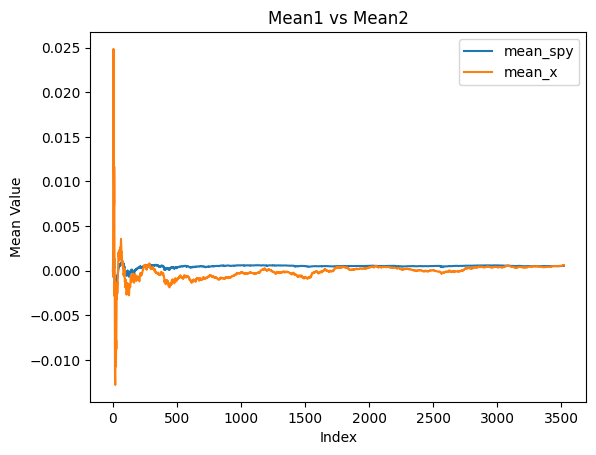

In [19]:
plt.plot(mean_spy, label='mean_spy')
plt.plot(mean_x, label='mean_x')
plt.title('Mean1 vs Mean2')
plt.xlabel('Index')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Minimum Variance Portfolio

In [ ]:
def get_mvp(var1,var2,cov):
    std1 = torch.sqrt(var1)
    std2 = torch.sqrt(var2)
    corr = cov/(std1*std2)
    nom = var2 - (corr*std1*std2)
    den = var1 + var2 - (2*corr*std1*std2)
    return nom/den

def get_capital_values(capital,w):
    return w * capital, (1-w)*capital

def get_return_values(returns,w):
    return w * returns + (1-w)*returns

In [ ]:
def get_VaR(alpha, mean, var):
    VaR = sps.norm.ppf(q=1-alpha,loc=mean,scale=var)
    return VaR

def get_ER(alpha, mean, var):
    q = sps.norm.ppf(q=1-alpha,loc=0,var=var)
    nom = sps.norm.pdf(q,loc=0,scale=1)
    return mean + var*(nom/(1-alpha))